# 0. Imports

In [1]:
from pipeline.load_activations import prepare_dataloaders
import torch
import torch.nn as nn
import gc
from torch.nn import CrossEntropyLoss
from torch.optim import Adam
from einops import einsum

In [110]:
def get_start_pos(token_ids: torch.Tensor) -> int:
    im_start_token = 151644
    im_start_positions = (token_ids == im_start_token).nonzero(as_tuple=True)[0]
    return im_start_positions[1].item()

## 1. Progress bar trajectories

In [ ]:
train_dataloader, test_dataloader, stats = prepare_dataloaders(
        activations_dir="/workspace/rollouts-big/activations",
        batch_size=1024,
        test_size=0.01,
        end_idx = 2000,
        shuffle = True
    )

2025-10-06 22:20:36,497 - INFO - Loading activations from: /workspace/rollouts-big/activations
2025-10-06 22:20:36,498 - INFO - Loading activations from index 0 to 2000
2025-10-06 22:20:38,029 - INFO - Loaded 100 activations
2025-10-06 22:20:39,331 - INFO - Loaded 200 activations
2025-10-06 22:20:40,861 - INFO - Loaded 300 activations
2025-10-06 22:20:42,262 - INFO - Loaded 400 activations
2025-10-06 22:20:43,924 - INFO - Loaded 500 activations
2025-10-06 22:20:45,427 - INFO - Loaded 600 activations
2025-10-06 22:20:46,959 - INFO - Loaded 700 activations
2025-10-06 22:20:48,467 - INFO - Loaded 800 activations
2025-10-06 22:20:50,053 - INFO - Loaded 900 activations
2025-10-06 22:20:51,476 - INFO - Loaded 1000 activations
2025-10-06 22:20:53,079 - INFO - Loaded 1100 activations
2025-10-06 22:20:54,693 - INFO - Loaded 1200 activations
2025-10-06 22:20:56,896 - INFO - Loaded 1300 activations
2025-10-06 22:21:00,333 - INFO - Loaded 1400 activations
2025-10-06 22:21:02,480 - INFO - Loaded 15

### linear to predict linear

In [3]:
all_acts = []
all_n_remaining = []

In [4]:
for activations, n_remaining, n_total in train_dataloader:
    all_acts.append(activations.to('cuda', dtype=torch.float32))
    all_n_remaining.append(n_remaining.to('cuda', dtype=torch.float32))

all_acts = torch.cat(all_acts)
all_n_remaining = torch.cat(all_n_remaining)


In [ ]:
all_acts = all_acts

torch.Size([1403562, 2560])

In [9]:
all_acts.isnan().sum()

tensor(0, device='cuda:0')

In [10]:
# Solve using normal equations: beta = (X^T X)^{-1} X^T y
XTX = all_acts.T @ all_acts
XTy = all_acts.T @ all_n_remaining
linear_to_linear_betas = torch.linalg.solve(XTX, XTy)

In [11]:
linear_to_linear_betas.shape

torch.Size([2560])

In [12]:
torch.save(linear_to_linear_betas, '/workspace/final_write_up/linear_to_linear_betas.pt')

### linear to predict log

In [13]:
# Solve using normal equations: beta = (X^T X)^{-1} X^T y
XTX = all_acts.T @ all_acts
XTy = all_acts.T @ (all_n_remaining + 1).log()
linear_to_log_betas = torch.linalg.solve(XTX, XTy)
torch.save(linear_to_log_betas, '/workspace/final_write_up/linear_to_log_betas.pt')

In [14]:
del all_acts, all_n_remaining, linear_to_linear_betas, linear_to_log_betas

gc.collect()
torch.cuda.empty_cache()

### bins classifier

In [15]:
class LogBinClassifer(nn.Module):
    def __init__(self, input_dim: int, n_bins: int):
        super().__init__()
        self.n_bins = n_bins
        self.linear = nn.Linear(input_dim, n_bins)

    def forward(self, x):
        return self.linear(x)

In [20]:
model = LogBinClassifer(2560, 10).to('cuda')
optimizer = Adam(model.parameters(), lr=1e-4)

In [21]:
loss_fn = CrossEntropyLoss()

In [22]:
n_bins = 11
def bin_y(y):
    return (y+1).log().floor().clamp(0,n_bins-1).to('cuda', dtype=torch.long)

In [ ]:
n_epochs = 3
for epoch in range(n_epochs):
    for activations, n_remaining, n_total in train_dataloader:
        optimizer.zero_grad()
        pred = model(activations.to('cuda', dtype=torch.float32))
        n_remaining_binned = bin_y(n_remaining)
        loss = loss_fn(pred, n_remaining_binned)
        loss.backward()
        optimizer.step()
        print(loss.item())
        

2.239861011505127
2.206599712371826
2.208305835723877
2.1977295875549316
2.1513068675994873
2.1231656074523926
2.1272852420806885
2.1199147701263428
2.0752995014190674
2.0763330459594727
2.080860137939453
2.082491159439087
2.058995008468628
2.021541118621826
2.0057213306427
1.99550461769104
1.9898747205734253
1.9720473289489746
1.9653269052505493
1.9730620384216309
1.9700201749801636
1.9314427375793457
1.9483355283737183
1.9652069807052612
1.90811026096344
1.8886442184448242
1.8819682598114014
1.8798828125
1.878554344177246
1.8440275192260742
1.8424221277236938
1.8442695140838623
1.8657467365264893
1.8458096981048584
1.8073556423187256
1.8213996887207031
1.811496615409851
1.8013811111450195
1.7739038467407227
1.7955113649368286
1.7634837627410889
1.7658519744873047
1.7561323642730713
1.7627129554748535
1.772189736366272
1.7743489742279053
1.7618129253387451
1.7019442319869995
1.7342498302459717
1.7221261262893677
1.7343058586120605
1.750671625137329
1.7456121444702148
1.714626431465149

KeyboardInterrupt: 

In [24]:
torch.save(model.state_dict(), '/workspace/final_write_up/log_bin_classifier.pt')

### using the randomly sampled from each sequence

In [109]:
import random

In [134]:
from concurrent.futures import ThreadPoolExecutor
import threading

def load_and_sample_activations(i):
    token_ids, activations = torch.load(f'/workspace/rollouts-big/activations/{i}.pt')
    start_pos = get_start_pos(token_ids)
    activations = activations[:, start_pos:]

    n_remaining = activations.shape[-2] - torch.arange(activations.shape[-2], device=activations.device)
    # Randomly sample 200 indices from the sequence
    random_indices = random.sample(range(activations.shape[-2]), min(200, activations.shape[-2]))
    random_indices = torch.tensor(random_indices, device=activations.device)
    chosen_activations = activations[:,random_indices]
    chosen_n_remaining = n_remaining[random_indices]
    print(f'{i} done')
    return chosen_activations, chosen_n_remaining

all_chosen_activations = []
all_chosen_n_remaining = []

with ThreadPoolExecutor(max_workers=8) as executor:
    results = list(executor.map(load_and_sample_activations, range(2000)))

for chosen_activations, chosen_n_remaining in results:
    all_chosen_activations.append(chosen_activations[0])
    all_chosen_n_remaining.append(chosen_n_remaining)

all_chosen_activations = torch.cat(all_chosen_activations)
all_chosen_n_remaining = torch.cat(all_chosen_n_remaining)



6 done
2 done
4 done
0 done
10 done
7 done
8 done
5 done
3 done
12 done
16 done
18 done
11 done
14 done
17 done
1 done
19 done
22 done
9 done
13 done
20 done
15 done
28 done
23 done
24 done
29 done
26 done
21 done
32 done
27 done
36 done
38 done
34 done
39 done
40 done
25 done
42 done
44 done
30 done
43 done
33 done
41 done
46 done
35 done
48 done
45 done
49 done
37 done
47 done
31 done
54 done
52 done
55 done
50 done
58 done
60 done
62 done
56 done
64 done
51 done
61 done
57 done
63 done
66 done
59 done
67 done
70 done
53 done
71 done
65 done
68 done
78 done
72 done
79 done
74 done
76 done
82 done
84 done
83 done
69 done
73 done
75 done
77 done
85 done
80 done
90 done
91 done
81 done
88 done
92 done
89 done
86 done
94 done
96 done
87 done
95 done
98 done
97 done
93 done
100 done
99 done
102 done
101 done
108 done
103 done
106 done
104 done
114 done
105 done
107 done
112 done
115 done
118 done
110 done
116 done
120 done
122 done
111 done
124 done
109 done
113 done
119 done
128 done
117

In [135]:
all_chosen_activations = all_chosen_activations.to('cuda', dtype=torch.float32)
all_chosen_n_remaining = all_chosen_n_remaining.to('cuda', dtype=torch.float32)


In [136]:
XtX = all_chosen_activations.T @ all_chosen_activations
XTy = all_chosen_activations.T @ all_chosen_n_remaining

lin_to_lin_betas = torch.linalg.solve(XtX, XTy)

In [137]:
torch.save(lin_to_lin_betas, '/workspace/final_write_up/balanced_lin_to_lin_betas.pt')

In [138]:
XTy = all_chosen_activations.T @ (all_chosen_n_remaining + 1).log()
lin_to_log_betas = torch.linalg.solve(XtX, XTy)
torch.save(lin_to_log_betas, '/workspace/final_write_up/balanced_lin_to_log_betas.pt')

### eval on test prompts

In [139]:
def sequence_to_pred_n_remaining_lin_to_lin(sequence: torch.Tensor, betas: torch.Tensor) -> torch.Tensor:
    pred_n_remaining = einsum(sequence, betas, 'b s d, d -> b s')[0].clamp(min=0) # s
    return pred_n_remaining

In [140]:
def sequence_to_pred_n_remaining_lin_to_log(sequence: torch.Tensor, betas: torch.Tensor) -> torch.Tensor:
    pred_n_remaining = einsum(sequence, betas, 'b s d, d -> b s')[0].exp() # s
    return pred_n_remaining

In [141]:
def sequence_to_pred_n_remaining_classifier(sequence: torch.Tensor, classifier: nn.Module) -> torch.Tensor:
    logits = classifier(sequence[0].to('cuda', dtype=torch.float32))
    probs = torch.softmax(logits, dim=1)
    n_bins = probs.shape[1]
    pred_n_remaining = torch.sum(probs * torch.arange(n_bins, device=logits.device), dim=1).exp()
    return pred_n_remaining

In [142]:
def pred_n_remaining_to_percent_estimate(pred_n_remaining: torch.Tensor) -> torch.Tensor:
    token_number = torch.arange(pred_n_remaining.shape[0], device=pred_n_remaining.device) 
    n_remaining_percent = token_number / (token_number + pred_n_remaining)
    return n_remaining_percent


In [153]:
def process_sequence(i):
    token_ids, sequence = torch.load(f'/workspace/rollouts-big/test/activations/{i}.pt')
    sequence = sequence.to('cuda')
    start_pos = get_start_pos(token_ids)
    sequence = sequence[:, start_pos:]
    actual_n_remaining = sequence.shape[1] - torch.arange(sequence.shape[1], device=sequence.device)
    lin_to_lin_betas = torch.load('/workspace/final_write_up/linear_to_linear_betas.pt').to('cuda', dtype = torch.bfloat16)
    lin_to_log_betas = torch.load('/workspace/final_write_up/linear_to_log_betas.pt').to('cuda', dtype = torch.bfloat16)
    balanced_lin_to_lin_betas = torch.load('/workspace/final_write_up/balanced_lin_to_lin_betas.pt').to('cuda', dtype = torch.bfloat16)
    balanced_lin_to_log_betas = torch.load('/workspace/final_write_up/balanced_lin_to_log_betas.pt').to('cuda', dtype = torch.bfloat16)
    lin_pred_n_remaining = sequence_to_pred_n_remaining_lin_to_lin(sequence, lin_to_lin_betas)
    log_pred_n_remaining = sequence_to_pred_n_remaining_lin_to_log(sequence, lin_to_log_betas)
    balanced_lin_pred_n_remaining = sequence_to_pred_n_remaining_lin_to_lin(sequence, balanced_lin_to_lin_betas)
    balanced_log_pred_n_remaining = sequence_to_pred_n_remaining_lin_to_log(sequence, balanced_lin_to_log_betas)
    classifier_pred_n_remaining = sequence_to_pred_n_remaining_classifier(sequence, model)
    lin_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(lin_pred_n_remaining)
    log_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(log_pred_n_remaining)
    balanced_lin_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(balanced_lin_pred_n_remaining)
    balanced_log_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(balanced_log_pred_n_remaining)
    classifier_pred_n_remaining_percent = pred_n_remaining_to_percent_estimate(classifier_pred_n_remaining)

    return {
        'lin_to_lin_percent': lin_pred_n_remaining_percent,
        'lin_to_log_percent': log_pred_n_remaining_percent,
        'log_bin_classifier_percent': classifier_pred_n_remaining_percent,
        'balanced_lin_to_lin_percent': balanced_lin_pred_n_remaining_percent,
        'balanced_lin_to_log_percent': balanced_log_pred_n_remaining_percent,
        'lin_to_lin_log': (lin_pred_n_remaining + 1).log(),
        'lin_to_log_log': (log_pred_n_remaining + 1).log(),
        'log_bin_classifier_log': (classifier_pred_n_remaining + 1).log(),
        'balanced_lin_to_lin_log': (balanced_lin_pred_n_remaining + 1).log(),
        'balanced_lin_to_log_log': (balanced_log_pred_n_remaining + 1).log(),
        'actual_n_remaining': actual_n_remaining,
        'log_n_tokens_remaining': (actual_n_remaining + 1).log()
    }

# Initialize lists
all_pred_percent_estimates = {'lin_to_lin': [None] * 1000, 'lin_to_log': [None] * 1000, 'log_bin_classifier': [None] * 1000, 'balanced_lin_to_lin': [None] * 1000, 'balanced_lin_to_log': [None] * 1000}
all_actual_n_remaining = [None] * 1000
all_log_pred_estimates = {'lin_to_lin': [None] * 1000, 'lin_to_log': [None] * 1000, 'log_bin_classifier': [None] * 1000, 'balanced_lin_to_lin': [None] * 1000, 'balanced_lin_to_log': [None] * 1000}
all_log_n_tokens_remaining = [None] * 1000

# Process sequences (can be parallelized)
from concurrent.futures import ThreadPoolExecutor
import threading

def process_and_store(i):
    result = process_sequence(i)
    all_pred_percent_estimates['lin_to_lin'][i] = result['lin_to_lin_percent']
    all_pred_percent_estimates['lin_to_log'][i] = result['lin_to_log_percent']
    all_pred_percent_estimates['log_bin_classifier'][i] = result['log_bin_classifier_percent']
    all_pred_percent_estimates['balanced_lin_to_lin'][i] = result['balanced_lin_to_lin_percent']
    all_pred_percent_estimates['balanced_lin_to_log'][i] = result['balanced_lin_to_log_percent']
    all_log_pred_estimates['lin_to_lin'][i] = result['lin_to_lin_log']
    all_log_pred_estimates['lin_to_log'][i] = result['lin_to_log_log']
    all_log_pred_estimates['log_bin_classifier'][i] = result['log_bin_classifier_log']
    all_log_pred_estimates['balanced_lin_to_lin'][i] = result['balanced_lin_to_lin_log']
    all_log_pred_estimates['balanced_lin_to_log'][i] = result['balanced_lin_to_log_log']
    all_actual_n_remaining[i] = result['actual_n_remaining']
    all_log_n_tokens_remaining[i] = result['log_n_tokens_remaining']
    print(i)

# Run in parallel
with ThreadPoolExecutor(max_workers=4) as executor:
    executor.map(process_and_store, range(1000))



2
0
3
1
4
6
8
7
5
10
9
14
12
11
16
13
17
18
19
20
15
21
24
22
23
26
25
27
28
30
32
31
34
33
29
38
35
36
39
37
40
42
44
41
43
46
45
48
49
50
47
52
54
51
56
53
55
57
58
60
59
64
62
66
61
65
63
68
67
72
70
69
74
73
71
75
76
78
77
79
82
80
84
83
81
85
86
90
87
91
88
89
94
92
96
93
98
95
97
100
101
102
99
104
106
103
107
108
105
110
112
111
109
114
113
115
118
116
119
120
117
122
124
121
123
126
128
125
127
129
132
130
131
136
134
137
133
135
140
138
139
141
142
144
145
143
146
148
147
150
149
152
151
153
156
154
157
158
155
160
162
161
159
163
164
166
165
167
170
168
171
169
172
176
173
174
177
178
175
180
182
179
181
184
183
185
186
187
188
189
190
192
191
194
193
195
196
197
198
199
202
200
204
201
206
205
208
203
207
209
210
214
212
216
213
211
215
217
218
220
219
221
222
224
223
226
228
225
227
230
232
229
231
234
233
236
238
235
237
240
241
242
244
243
239
245
246
248
247
250
249
252
251
254
256
255
253
257
260
258
262
261
259
263
264
266
268
265
267
270
272
271
269
273
274
276
278
27

In [154]:
import matplotlib.pyplot as plt

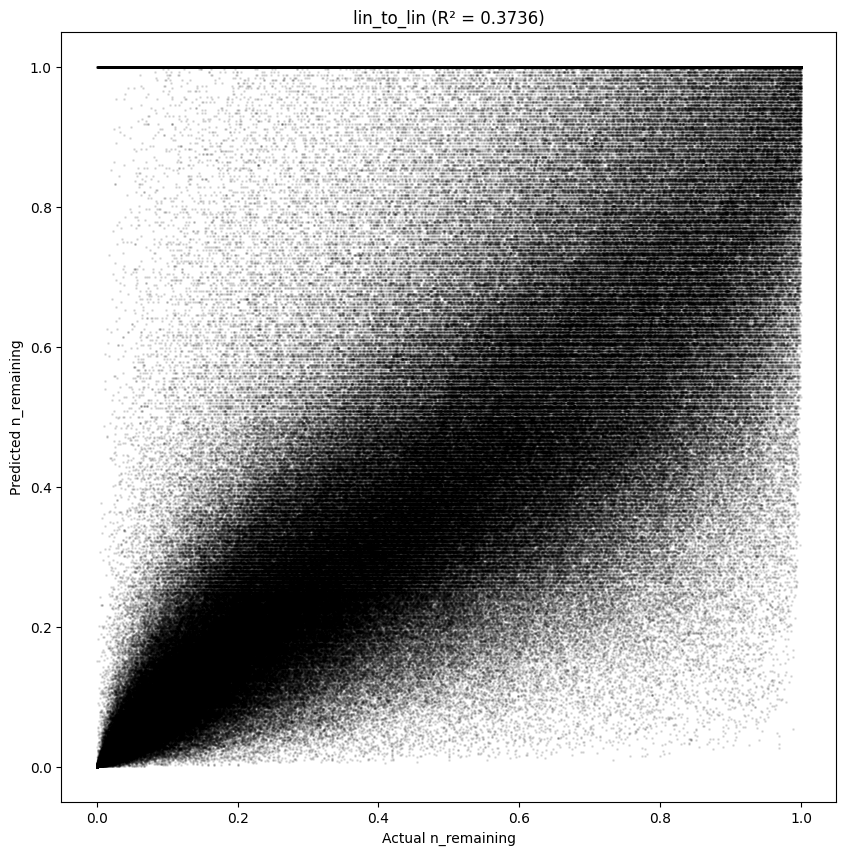

<Figure size 640x480 with 0 Axes>

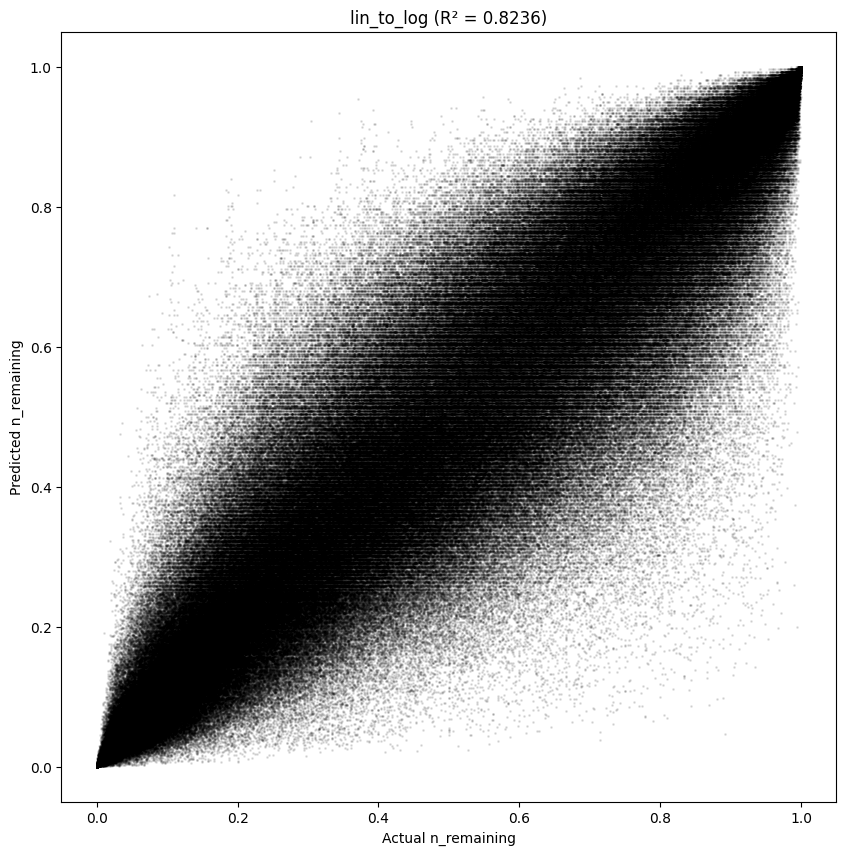

<Figure size 640x480 with 0 Axes>

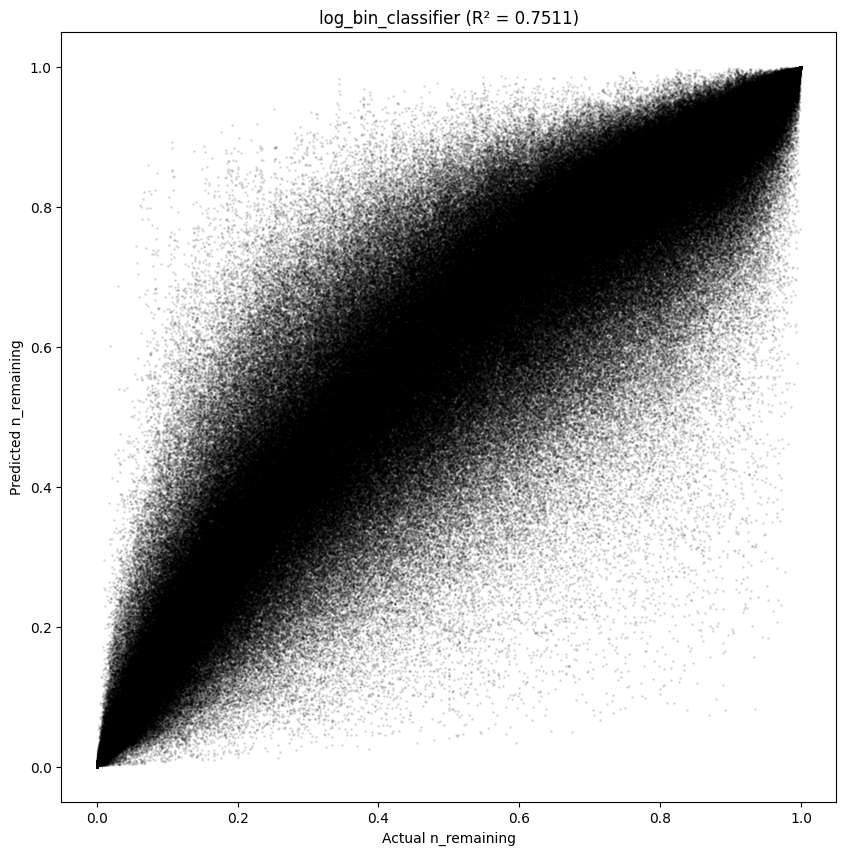

<Figure size 640x480 with 0 Axes>

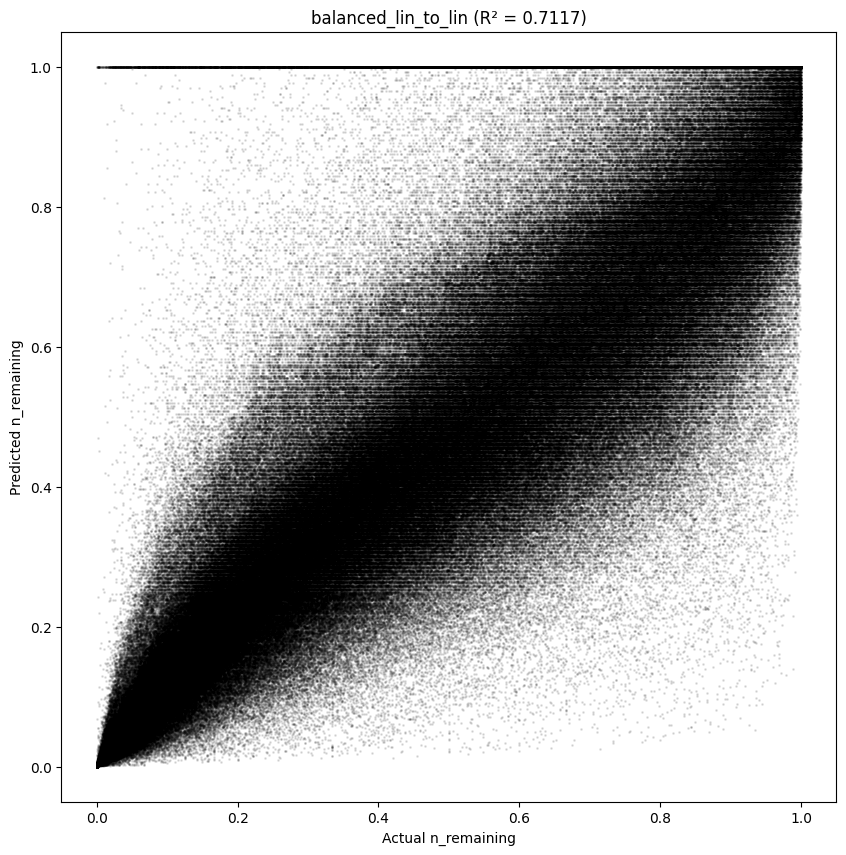

<Figure size 640x480 with 0 Axes>

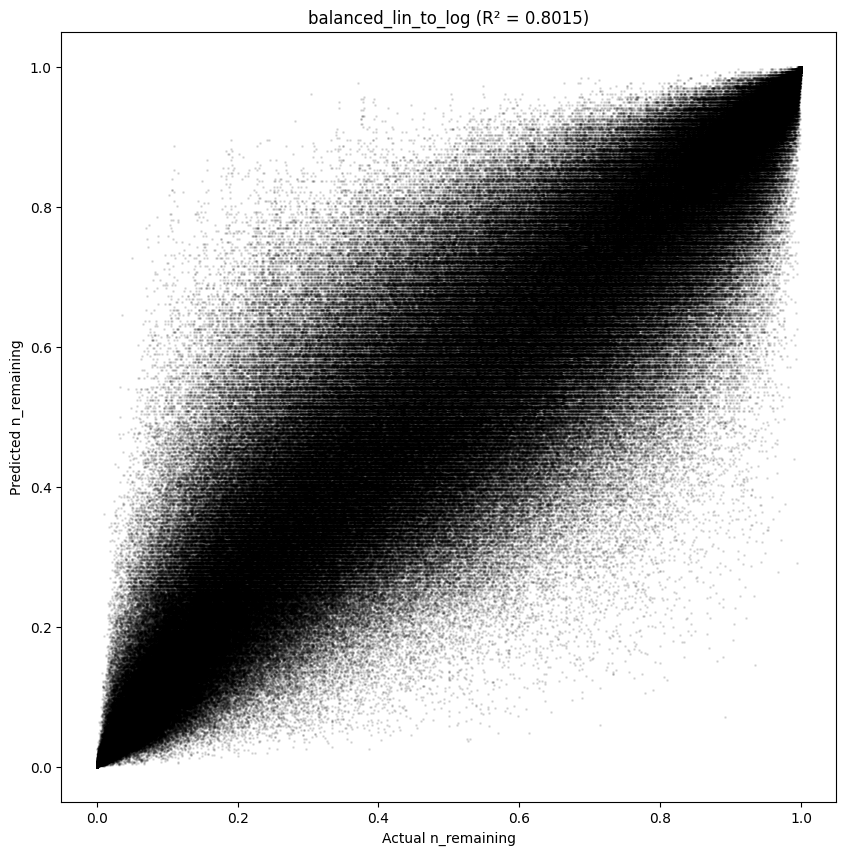

<Figure size 640x480 with 0 Axes>

In [155]:
from sklearn.metrics import r2_score
import numpy as np

for model_type in all_pred_percent_estimates.keys():
    plt.figure(figsize=(10, 10))
    
    # Collect all actual and predicted values for R2 calculation
    all_actual = []
    all_predicted = []
    
    for i in range(len(all_pred_percent_estimates[model_type])):
        actual = 1-(all_actual_n_remaining[i]/len(all_actual_n_remaining[i])).float().detach().cpu().numpy()
        predicted = all_pred_percent_estimates[model_type][i].float().detach().cpu().numpy()
        
        all_actual.extend(actual)
        all_predicted.extend(predicted)
        
        plt.scatter(actual, predicted, alpha=0.1, s=1, c='black')
    
    # Calculate R2
    # Filter out NaN values
    all_actual_array = np.array(all_actual)
    all_predicted_array = np.array(all_predicted)
    
    # Create mask for non-NaN values
    mask = ~(np.isnan(all_actual_array) | np.isnan(all_predicted_array))
    
    # Calculate R2 only on non-NaN values
    r2 = r2_score(all_actual_array[mask], all_predicted_array[mask])
    
    plt.title(f'{model_type} (R² = {r2:.4f})')
    plt.xlabel('Actual n_remaining')
    plt.ylabel('Predicted n_remaining')
    plt.show()
    
    plt.savefig(f'/workspace/final_write_up/plots/{model_type}.png')


## 2. predicted n_tokens_remaining vs actual R^2 for good and bad data mix (and logistic classifiers on each of these)

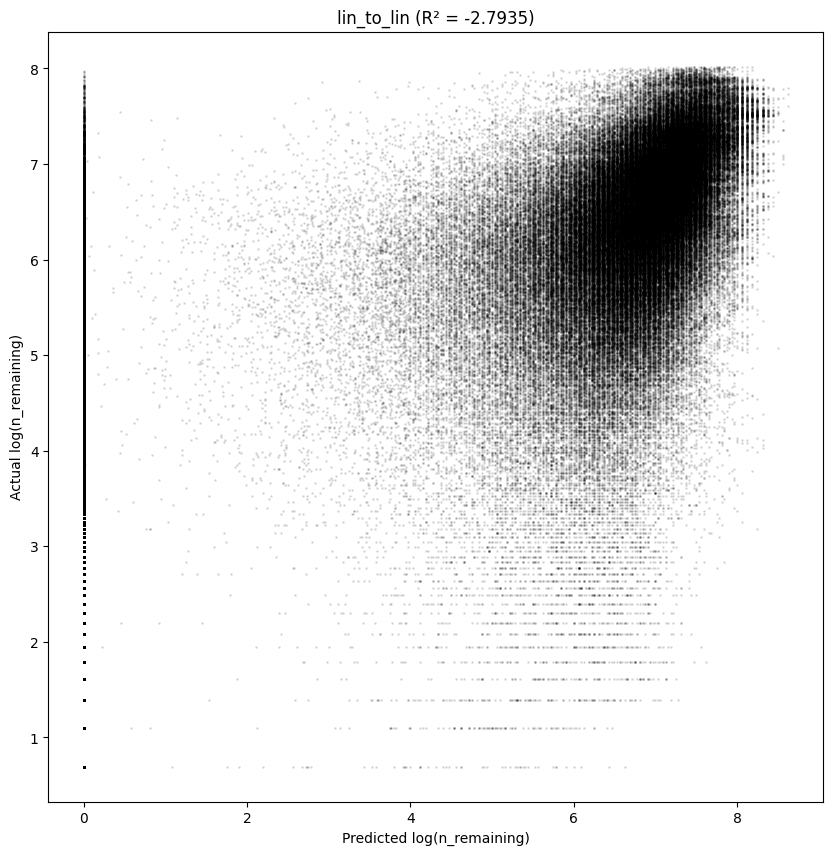

<Figure size 640x480 with 0 Axes>

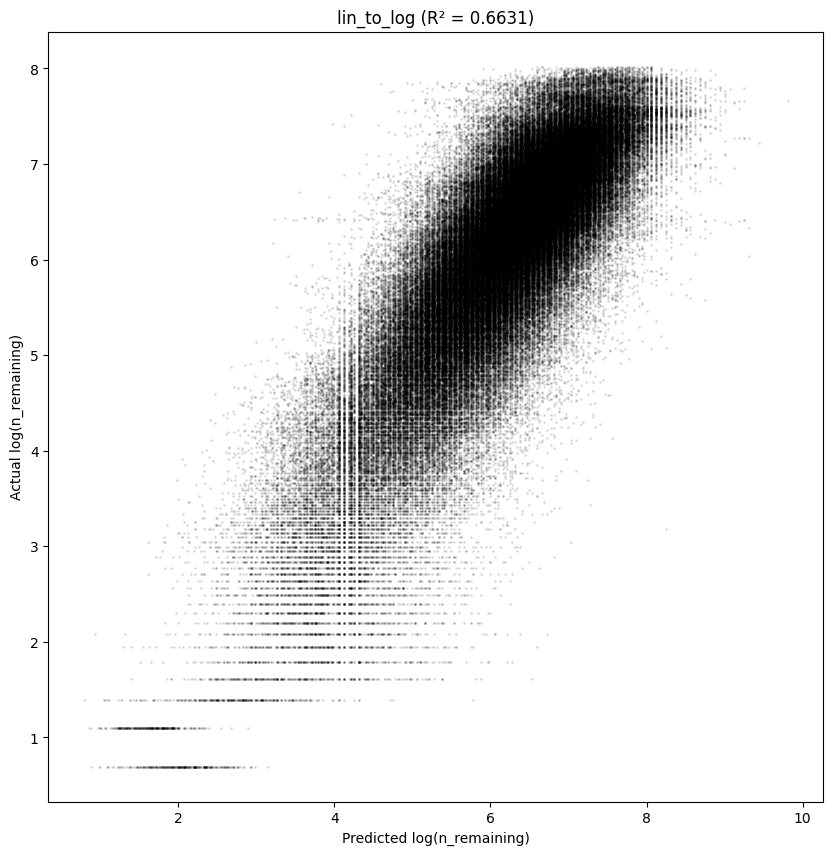

<Figure size 640x480 with 0 Axes>

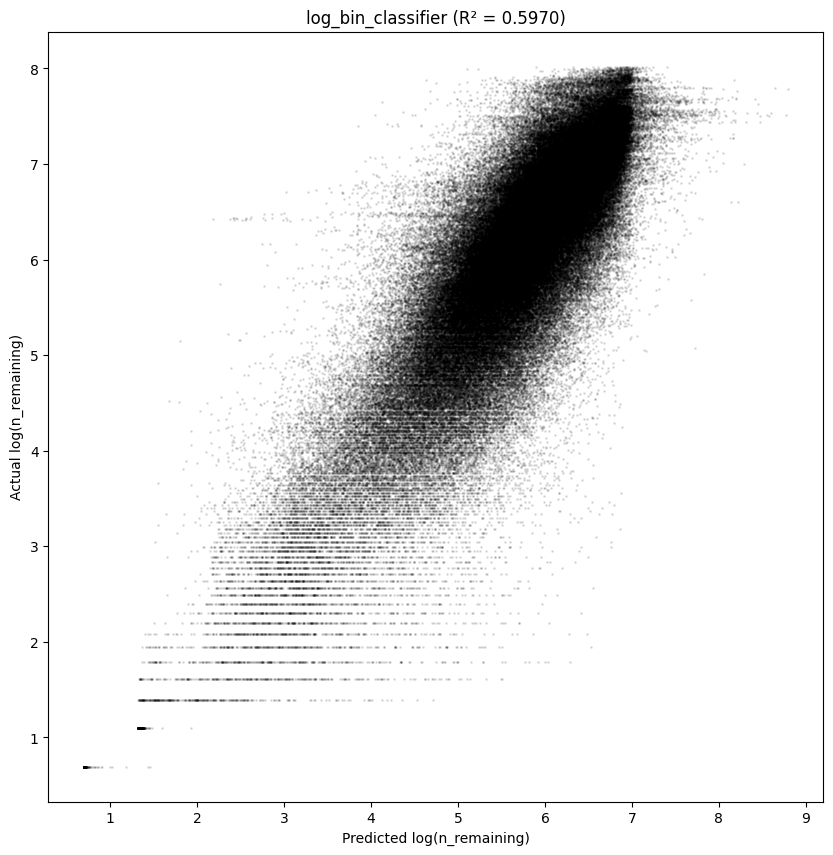

<Figure size 640x480 with 0 Axes>

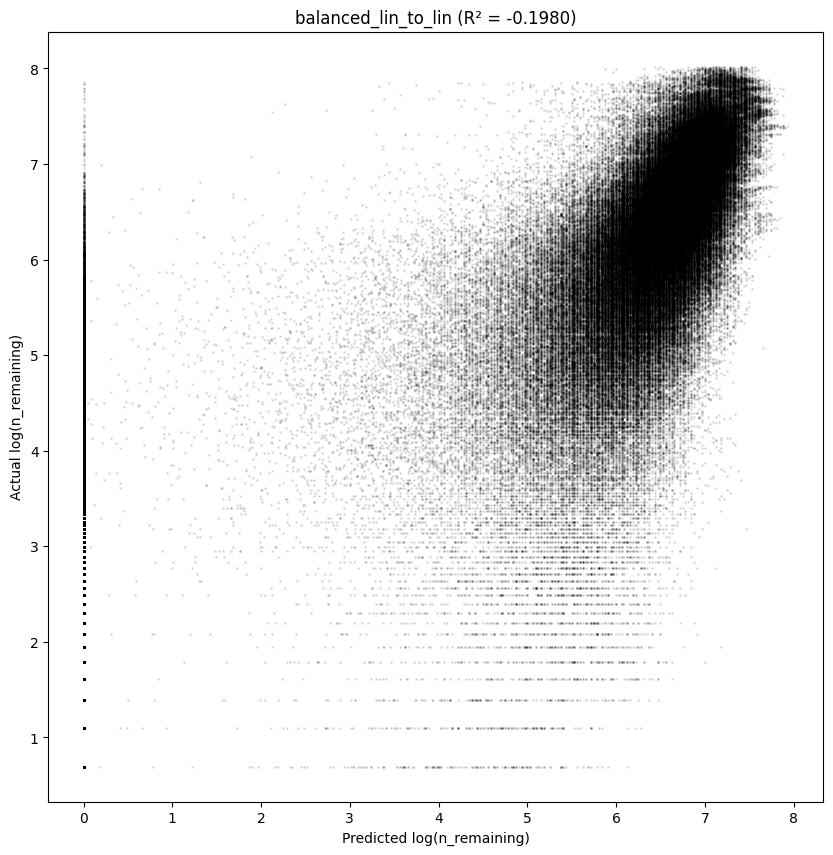

<Figure size 640x480 with 0 Axes>

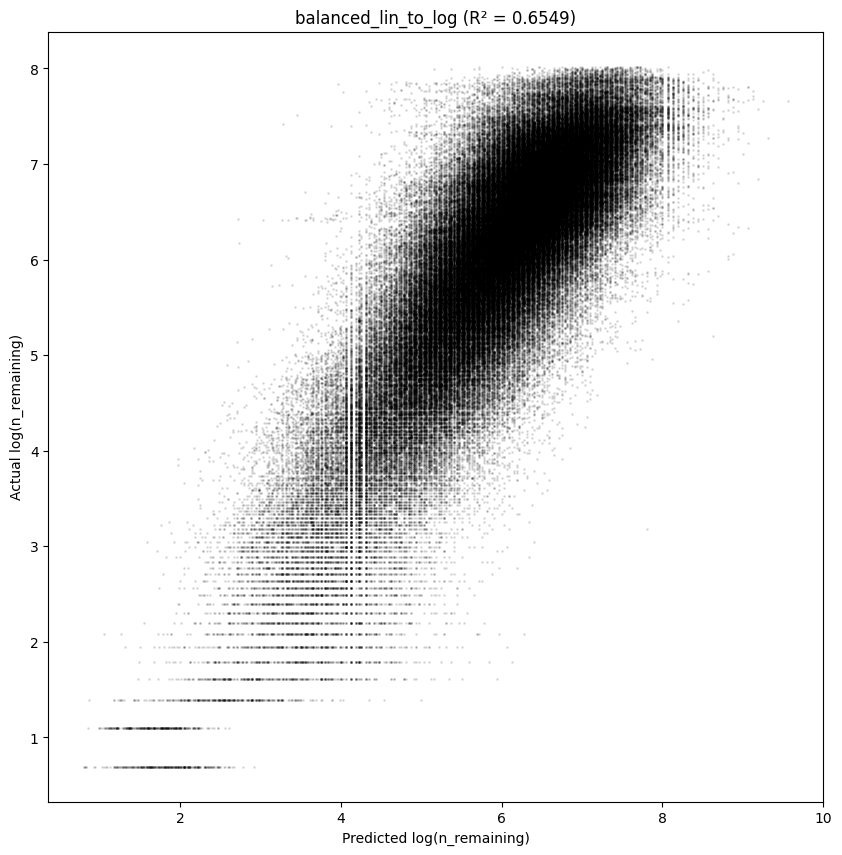

<Figure size 640x480 with 0 Axes>

In [151]:
from sklearn.metrics import r2_score
import numpy as np

for model_type in all_log_pred_estimates.keys():
    plt.figure(figsize=(10, 10))
    
    # Collect all actual and predicted values for R2 calculation
    all_actual = []
    all_predicted = []
    
    for i in range(len(all_log_pred_estimates[model_type])):
        actual = all_log_n_tokens_remaining[i].float().detach().cpu().numpy()
        predicted = all_log_pred_estimates[model_type][i].float().detach().cpu().numpy()
        
        all_actual.extend(actual)
        all_predicted.extend(predicted)
        
        plt.scatter(predicted, actual, alpha=0.1, s=1, c='black')
    
    # Calculate R2
    r2 = r2_score(all_actual, all_predicted)
    
    plt.title(f'{model_type} (R² = {r2:.4f})')
    plt.xlabel('Predicted log(n_remaining)')
    plt.ylabel('Actual log(n_remaining)')
    plt.show()
    
    plt.savefig(f'/workspace/final_write_up/plots/{model_type}_log.png')


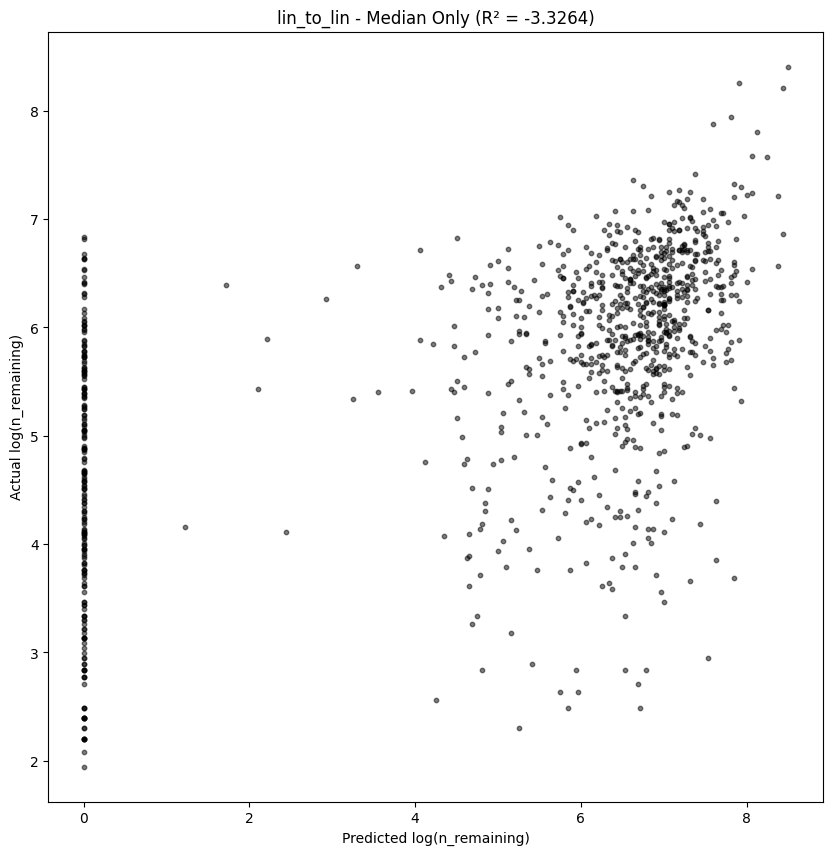

<Figure size 640x480 with 0 Axes>

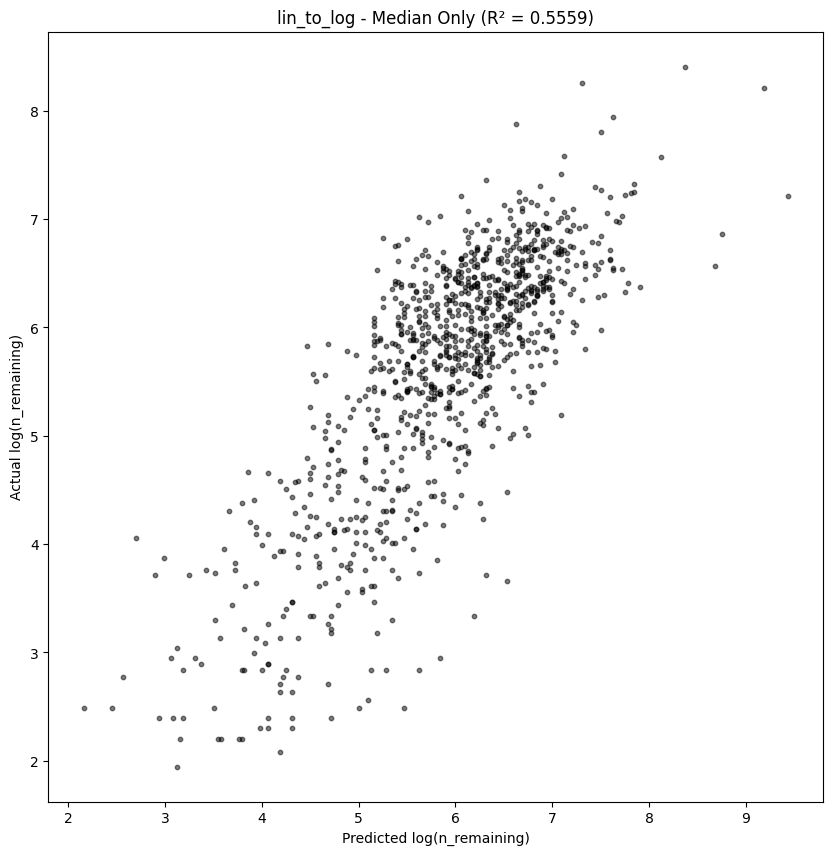

<Figure size 640x480 with 0 Axes>

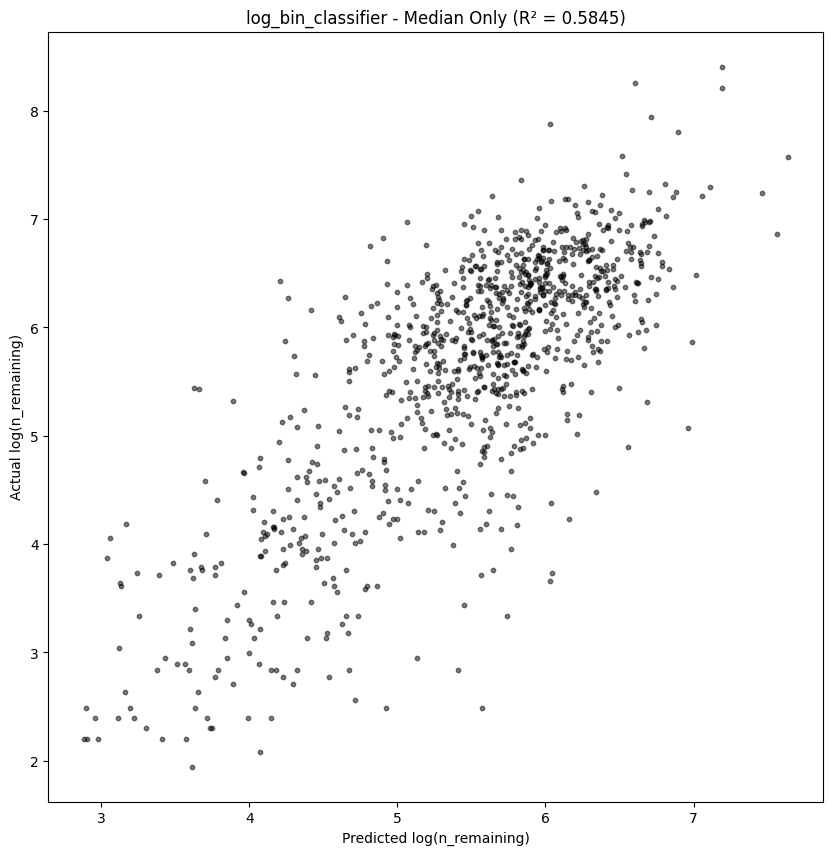

<Figure size 640x480 with 0 Axes>

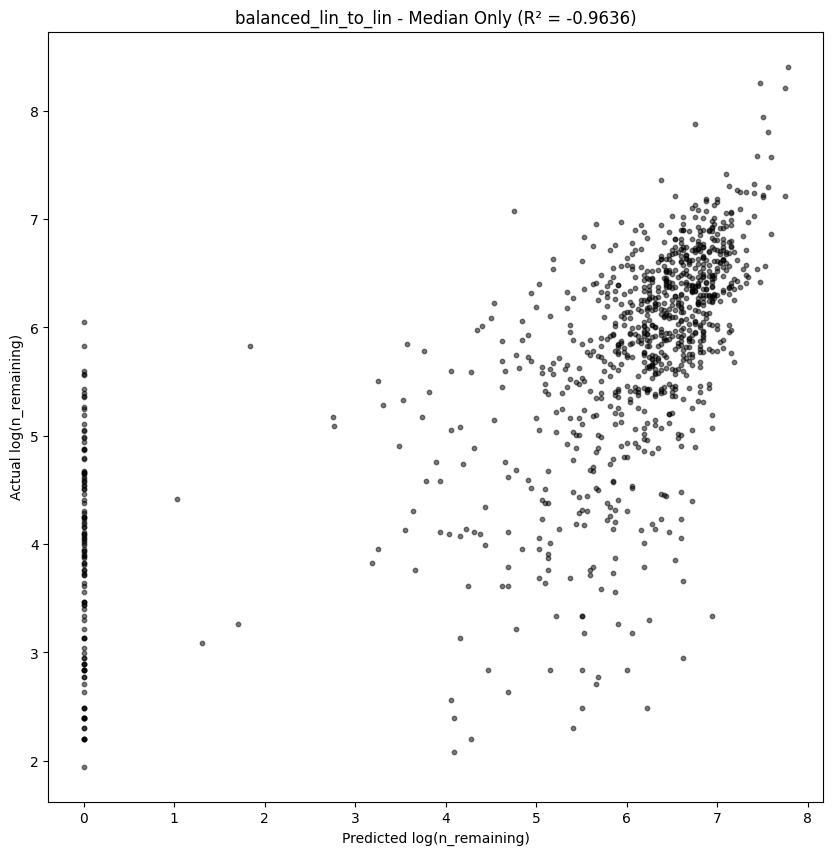

<Figure size 640x480 with 0 Axes>

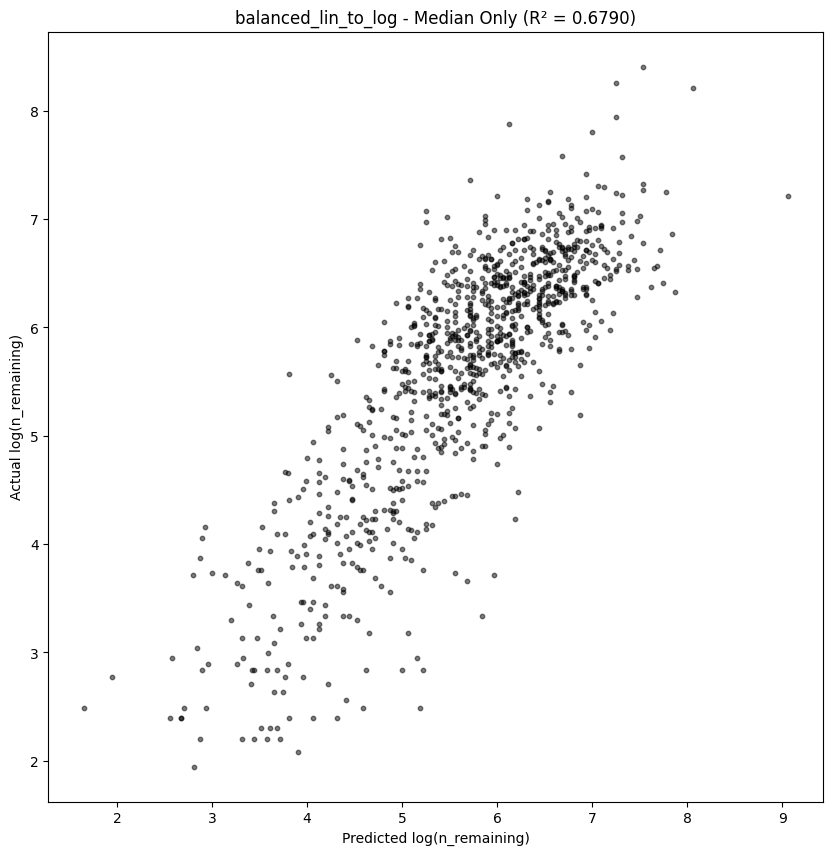

<Figure size 640x480 with 0 Axes>

In [156]:
from sklearn.metrics import r2_score
import numpy as np

for model_type in all_log_pred_estimates.keys():
    plt.figure(figsize=(10, 10))
    
    # Collect all actual and predicted values for R2 calculation (median idx only)
    all_actual = []
    all_predicted = []
    
    for i in range(len(all_log_pred_estimates[model_type])):
        actual = all_log_n_tokens_remaining[i].float().detach().cpu().numpy()
        predicted = all_log_pred_estimates[model_type][i].float().detach().cpu().numpy()
        
        # Take only the median index for each sequence
        median_idx = len(actual) // 2
        all_actual.append(actual[median_idx])
        all_predicted.append(predicted[median_idx])
        
        plt.scatter(predicted[median_idx], actual[median_idx], alpha=0.5, s=10, c='black')
    
    # Calculate R2
    r2 = r2_score(all_actual, all_predicted)
    
    plt.title(f'{model_type} - Median Only (R² = {r2:.4f})')
    plt.xlabel('Predicted log(n_remaining)')
    plt.ylabel('Actual log(n_remaining)')
    plt.show()
    
    plt.savefig(f'/workspace/final_write_up/plots/{model_type}_log_median.png')



Progress point: 0.10
lin_to_log: R² = 0.4630
balanced_lin_to_log: R² = 0.6507
log_bin_classifier: R² = 0.4477

Progress point: 0.20
lin_to_log: R² = 0.4906
balanced_lin_to_log: R² = 0.6529
log_bin_classifier: R² = 0.4836

Progress point: 0.30
lin_to_log: R² = 0.5236
balanced_lin_to_log: R² = 0.6916
log_bin_classifier: R² = 0.5379

Progress point: 0.40
lin_to_log: R² = 0.5196
balanced_lin_to_log: R² = 0.6829
log_bin_classifier: R² = 0.5209

Progress point: 0.50
lin_to_log: R² = 0.4676
balanced_lin_to_log: R² = 0.6835
log_bin_classifier: R² = 0.5449

Progress point: 0.60
lin_to_log: R² = 0.3493
balanced_lin_to_log: R² = 0.6100
log_bin_classifier: R² = 0.4940

Progress point: 0.70
lin_to_log: R² = 0.2280
balanced_lin_to_log: R² = 0.5220
log_bin_classifier: R² = 0.4810

Progress point: 0.80
lin_to_log: R² = 0.0413
balanced_lin_to_log: R² = 0.3820
log_bin_classifier: R² = 0.3669

Progress point: 0.90
lin_to_log: R² = -0.4205
balanced_lin_to_log: R² = -0.0061
log_bin_classifier: R² = 0.0494

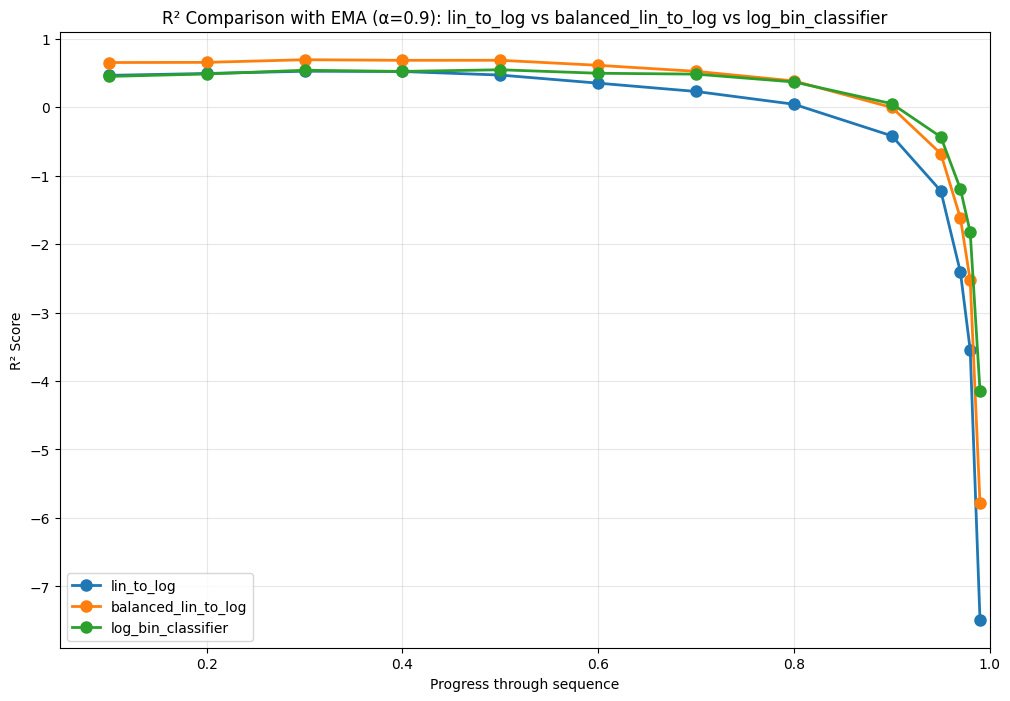

<Figure size 640x480 with 0 Axes>

In [ ]:
from sklearn.metrics import r2_score
import numpy as np
import torch
# Compare lin_to_log, balanced_lin_to_log, and log_bin_classifier at different progress points
progress_points = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95, 0.97,0.98,0.99]
model_types = ['lin_to_log', 'balanced_lin_to_log', 'log_bin_classifier']

results = {model_type: [] for model_type in model_types}

for progress in progress_points:
    print(f"\nProgress point: {progress:.2f}")
    
    for model_type in model_types:
        if model_type not in all_log_pred_estimates:
            continue
            
        all_actual = []
        all_predicted = []
        
        for i in range(len(all_log_pred_estimates[model_type])):
            actual = all_log_n_tokens_remaining[i].float()
            predicted = all_log_pred_estimates[model_type][i].float()
            
            # Calculate the index for this progress point
            progress_idx = int(len(actual) * progress)
            if progress_idx >= len(actual):
                progress_idx = len(actual) - 1
                
            all_actual.append(actual[progress_idx].detach().cpu().numpy())
            all_predicted.append(predicted[progress_idx].detach().cpu().numpy())
        
        # Calculate R2
        r2 = r2_score(all_actual, all_predicted)
        results[model_type].append(r2)
        print(f"{model_type}: R² = {r2:.4f}")

# Plot comparison
plt.figure(figsize=(12, 8))
for model_type in model_types:
    if model_type in results and results[model_type]:
        plt.plot(progress_points, results[model_type], marker='o', linewidth=2, markersize=8, label=model_type)

plt.xlabel('Progress through sequence')
plt.ylabel('R² Score')
plt.title('R² Comparison: lin_to_log vs balanced_lin_to_log vs log_bin_classifier')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xlim(0.05, 1.0)
plt.show()

plt.savefig('/workspace/final_write_up/plots/r2_comparison_progress.png', dpi=300, bbox_inches='tight')


## 3. n_tokens before < / think>

## 4. R2 of predicted tokens with EMA = 0.9 and EMA = 0

show here that we do not benefit from more data